### importing lib.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set()
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets ,transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split

### importing img to variables

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize((0.0,), (1.0,)),
    
])

train_data = datasets.ImageFolder(root="asl_alphabet_train" , transform =transform)

from sklearn.model_selection import train_test_split
train_dataset, val_dataset = train_test_split(train_data, test_size=0.1)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=True)

###  checking with eg.

In [4]:
print(train_data.class_to_idx)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


P


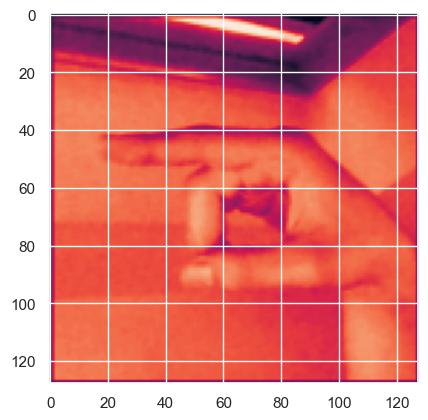

In [5]:
img , label =train_dataset[13330]
plt.imshow(np.array(img).reshape(128,128))
print(train_data.classes[label])


Y


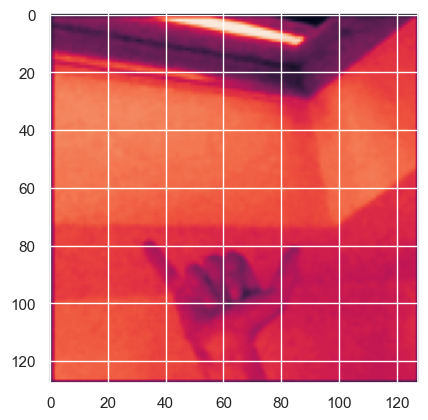

In [6]:
img , labels =val_dataset[230]
plt.imshow(np.array(img).reshape(128,128))
print(train_data.classes[labels])

### Model

In [7]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1)
        self.fc1 = nn.Linear(256*6*6, 256)
        # self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        # self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 29)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 256*6*6)
        x = F.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [8]:
model = ConvolutionalNetwork()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters() , lr=0.0005 )
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0007, weight_decay=1e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

### Train and validation

In [9]:
b=0
a=0
epoch = 10
train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in range (epoch):
    # train_corr= 0
    # val_corr = 0

    for b ,(x_train,y_train) in enumerate (train_loader):
        x_train, y_train = x_train.to(device), y_train.to(device)
        b+=1
        y_pred = model(x_train)
        loss= criterion(y_pred , y_train)
        predicted_t = torch.max(y_pred.data,1)[1]
        batcht_corr =(predicted_t==y_train).sum().item()
        a = len(y_train)
        # train_corr += batcht_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.detach().item())
    train_correct.append(batcht_corr)

    print(f"done {i+1}th epoch and loss={loss}")

    with torch.no_grad():
        for b , (x_val ,y_val) in enumerate(val_loader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_val_pred = model(x_val)
            predicted_v = torch.max(y_val_pred.data, 1)[1]
            batchv_corr = (predicted_v == y_val).sum().item()
            b= len(y_val)
            # val_corr += batchv_corr

        loss_val = criterion (y_val_pred , y_val)
    val_losses.append(loss_val.detach().item())
    val_correct.append(batchv_corr)

    scheduler.step(loss_val)

    print(f"train loss: {loss:.3f} , val loss : {loss_val:.3f} , train accuracy : {batcht_corr/a*100:.3f}% , val acccuracy : {batchv_corr/b*100:.3f}%")

done 1th epoch and loss=0.14211170375347137
train loss: 0.142 , val loss : 0.243 , train accuracy : 96.429% , val acccuracy : 93.000%
done 2th epoch and loss=0.06675756722688675
train loss: 0.067 , val loss : 0.150 , train accuracy : 96.429% , val acccuracy : 95.000%
done 3th epoch and loss=0.022771699354052544
train loss: 0.023 , val loss : 0.029 , train accuracy : 100.000% , val acccuracy : 99.000%
done 4th epoch and loss=0.036040060222148895
train loss: 0.036 , val loss : 0.036 , train accuracy : 100.000% , val acccuracy : 99.500%
done 5th epoch and loss=0.00636244798079133
train loss: 0.006 , val loss : 0.022 , train accuracy : 100.000% , val acccuracy : 98.500%
done 6th epoch and loss=0.217613086104393
train loss: 0.218 , val loss : 0.067 , train accuracy : 92.857% , val acccuracy : 98.000%
done 7th epoch and loss=0.0013163834810256958
train loss: 0.001 , val loss : 0.020 , train accuracy : 100.000% , val acccuracy : 99.500%
done 8th epoch and loss=0.014398162253201008
train loss:

### analyzing model


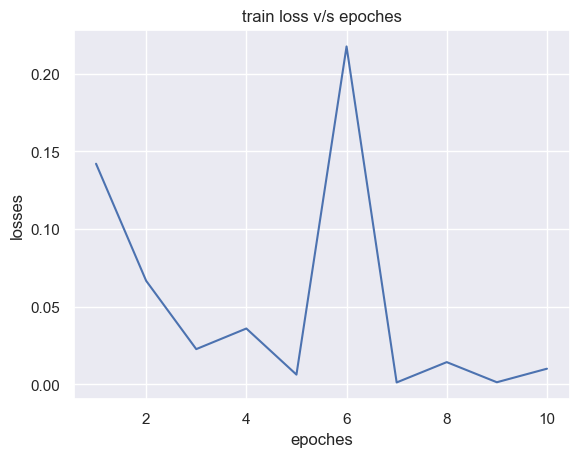

In [10]:
epo= [ i for i in range(1,11,1)]
plt.plot(epo , np.array(train_losses))
plt.xlabel("epoches")
plt.ylabel("losses")
plt.title("train loss v/s epoches")
plt.show()

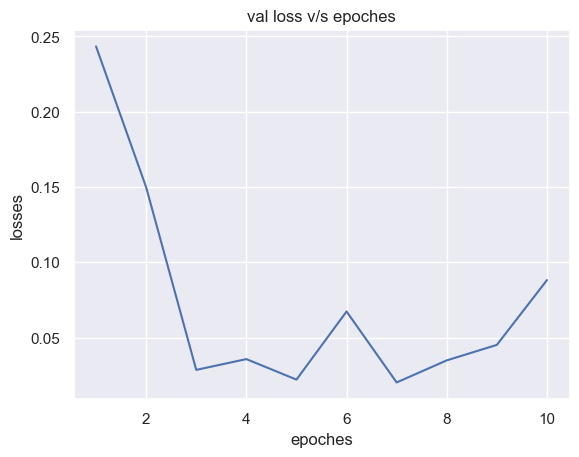

In [11]:
epo= [ i for i in range(1,11,1)]
plt.plot(epo , val_losses)
plt.xlabel("epoches")
plt.ylabel("losses")
plt.title("val loss v/s epoches")
plt.show()

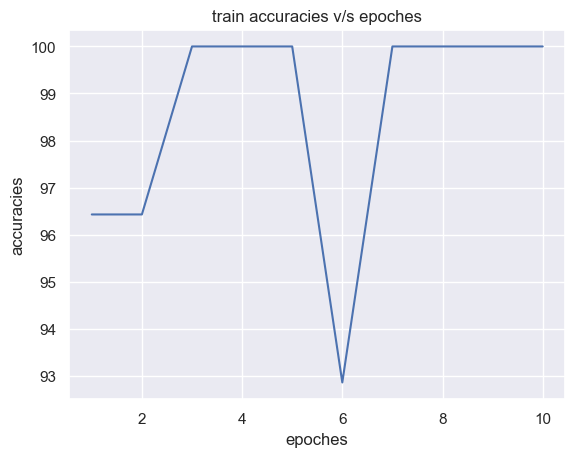

In [12]:

plt.plot(epo , [i/a*100 for i in (train_correct)])
plt.xlabel("epoches")
plt.ylabel("accuracies")
plt.title("train accuracies v/s epoches")
plt.show()

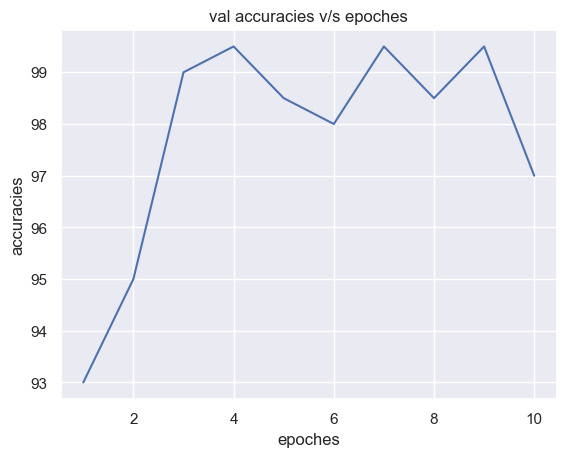

In [13]:

plt.plot(epo , [i/b*100 for i in (val_correct)])
plt.xlabel("epoches")
plt.ylabel("accuracies")
plt.title("val accuracies v/s epoches")
plt.show()

### testing the data

In [14]:
import os
from PIL import Image

def load_test_images(folder_path):
    test_images = []
    test_filenames = []
    for file in os.listdir(folder_path):
        if file.endswith(( ".jpg")): 
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path).convert("L") 
            img = transform(img)
            test_images.append(img)
            test_filenames.append(file)
    return test_images, test_filenames

test_images, test_filenames = load_test_images("asl_alphabet_test")

In [15]:
test_class = [ i.replace("_test.jpg" , "") for i in test_filenames]
test_label = [ train_data.class_to_idx[label_t] for label_t in test_class]

In [16]:
from torch.utils.data import  TensorDataset
test_dataset = TensorDataset(torch.stack(test_images))  # Stack images into a single tensor
test_loader = DataLoader(test_dataset, batch_size=29, shuffle=False)

In [17]:
model.eval()
all_pred_test = []
with torch.no_grad():
    for x_test in test_loader:
        x_test = x_test[0].to(device)  
        outputs = model(x_test)
        pred_test = torch.argmax(outputs, dim=1) 
        all_pred_test.extend(pred_test.cpu().numpy())

In [18]:
all_pred_test = np.array(all_pred_test)
test_label = np.array(test_label)

### Accuracy, precision, recall, f1 scores and  confussion matrix

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [20]:
acc = accuracy_score(test_label , all_pred_test)
precision = precision_score(test_label , all_pred_test,average='weighted')
recall =  recall_score(test_label , all_pred_test , average='weighted')
f1 = f1_score(test_label , all_pred_test , average='weighted')
conf_matrix = confusion_matrix(test_label , all_pred_test)

In [21]:
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Confusion Matrix:
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 

### Save 


In [23]:
import pickle 
with open ('SignVision_model' , 'wb') as file :
    pickle.dump(model , file)